<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/NODE_(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NODE (Neural Oblivious Decision Ensembles) for Agricultural Production Classification - 3 Classes
Loading data...
Train shape: (3584, 84)
Validation shape: (768, 84)
Test shape: (768, 84)
Preprocessing features...
Creating quantile-based labels (3 classes)...
Tercile thresholds: [1018. 3979.]
Label distribution:
Low: 1184 (33.0%)
Medium: 1218 (34.0%)
High: 1182 (33.0%)
Feature dimensions: 83
Number of classes: 3

Initializing NODE model...
Model built with 236291 parameters

Training NODE model...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.3455 - loss: 1.4467 - val_accuracy: 0.3346 - val_loss: 2.8561 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3550 - loss: 1.2642 - val_accuracy: 0.3346 - val_loss: 1.3793 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3735 - loss: 1.2118 - val_accuracy: 0.3529 - val_loss: 1.4066 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1

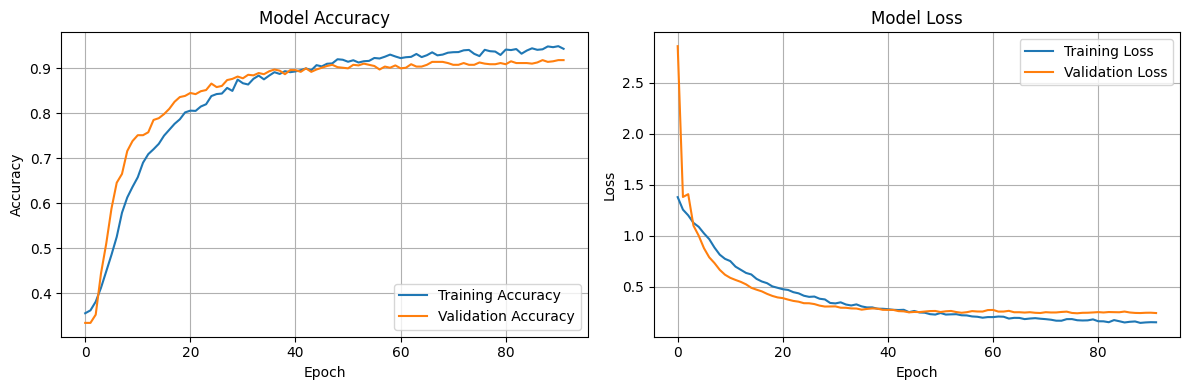


Making predictions...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Validation Classification Metrics:
--------------------------------------------------
Accuracy: 0.9102
Precision (Macro): 0.9110
Precision (Weighted): 0.9100
Recall (Macro): 0.9112
Recall (Weighted): 0.9102
F1 Score (Macro): 0.9111
F1 Score (Weighted): 0.9101

Detailed Classification Report (Validation):
              precision    recall  f1-score   support

         Low       0.96      0.96      0.96       247
      Medium       0.87      0.87      0.87       264
        High       0.91      0.91      0.91       257

    accuracy                           0.91       768
   macro avg       0.91      0.91      0.91       768
weighted avg       0.91      0.91      0.91       768


Test Classification Metrics:
--------------------------------------------------
Accuracy: 0.9167
Precision (Macro): 0.9204
Precision (Weighted): 0.9190
Recall (Macro): 0.9165
Recall (Weighted): 0.9167
F1 Score 

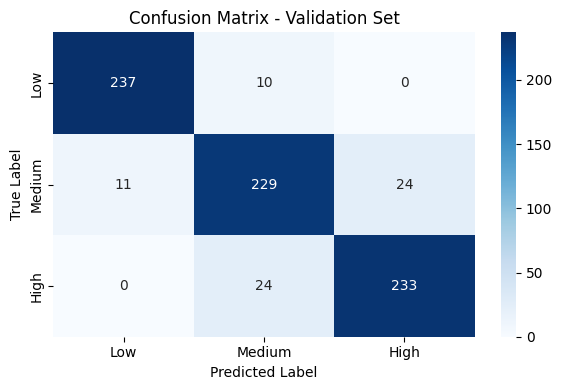

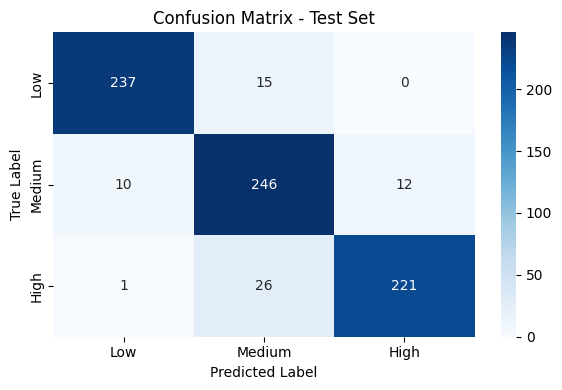


FINAL RESULTS SUMMARY
Validation Accuracy: 0.9102
Validation Macro F1: 0.9111
Validation Weighted F1: 0.9101

Test Accuracy: 0.9167
Test Macro F1: 0.9178
Test Weighted F1: 0.9171

Tercile Thresholds Used:
Low: ≤ 1018.000
Medium: 1018.000 - 3979.000
High: > 3979.000

Model training and evaluation completed successfully!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class NODEModel:
    """
    Neural Oblivious Decision Ensembles (NODE) implementation
    """

    def __init__(self, input_dim, num_classes, num_layers=3, tree_depth=6, num_trees=2048,
                 learning_rate=0.001, batch_size=512):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.tree_depth = tree_depth
        self.num_trees = num_trees
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = None
        self.history = None

    def build_model(self):
        """Build the NODE model architecture"""
        inputs = layers.Input(shape=(self.input_dim,))

        # Feature preprocessing
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        # NODE layers (simplified implementation)
        for i in range(self.num_layers):
            # Oblivious decision tree simulation
            choice_function = layers.Dense(2**self.tree_depth, activation='sigmoid')(x)
            feature_selection = layers.Dense(self.tree_depth, activation='softmax')(x)

            # Tree ensemble
            tree_outputs = []
            for j in range(min(8, self.num_trees // (2**i + 1))):  # Reduced for computational efficiency
                tree_branch = layers.Dense(64, activation='relu')(x)
                tree_branch = layers.Dropout(0.2)(tree_branch)
                tree_outputs.append(tree_branch)

            if tree_outputs:
                x = layers.Add()(tree_outputs) if len(tree_outputs) > 1 else tree_outputs[0]

            x = layers.Dense(128, activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.2)(x)

        # Final classification layer
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs)

        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, verbose=1):
        """Train the NODE model"""
        if self.model is None:
            self.build_model()

        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
        )

        # Train model
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=self.batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=verbose
        )

        return self.history

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)

    def predict_classes(self, X):
        """Predict class labels"""
        predictions = self.predict(X)
        return np.argmax(predictions, axis=1)

def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    print("Loading data...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Validation shape: {val_df.shape}")
    print(f"Test shape: {test_df.shape}")

    return train_df, val_df, test_df

def create_quantile_labels(df, target_col='Production (M.Ton)'):
    """Create quantile-based labels for production (3 classes)"""
    print("Creating quantile-based labels (3 classes)...")

    # Calculate terciles (33rd and 67th percentiles)
    quantiles = df[target_col].quantile([0.33, 0.67]).values
    print(f"Tercile thresholds: {quantiles}")

    # Create labels
    def get_label(value):
        if value <= quantiles[0]:
            return 0  # Low
        elif value <= quantiles[1]:
            return 1  # Medium
        else:
            return 2  # High

    labels = df[target_col].apply(get_label)

    # Print label distribution
    label_names = ['Low', 'Medium', 'High']
    print("Label distribution:")
    for i, name in enumerate(label_names):
        count = (labels == i).sum()
        print(f"{name}: {count} ({count/len(labels)*100:.1f}%)")

    return labels, quantiles

def preprocess_features(train_df, val_df, test_df, target_col='Production (M.Ton)'):
    """Preprocess features and prepare data for training"""
    print("Preprocessing features...")

    # Separate features and target
    feature_cols = [col for col in train_df.columns if col != target_col]

    X_train = train_df[feature_cols].copy()
    X_val = val_df[feature_cols].copy()
    X_test = test_df[feature_cols].copy()

    # Create labels
    y_train, train_quantiles = create_quantile_labels(train_df, target_col)

    # Use train quantiles for validation and test sets
    def apply_train_quantiles(df, quantiles, target_col):
        def get_label(value):
            if value <= quantiles[0]:
                return 0  # Low
            elif value <= quantiles[1]:
                return 1  # Medium
            else:
                return 2  # High
        return df[target_col].apply(get_label)

    y_val = apply_train_quantiles(val_df, train_quantiles, target_col)
    y_test = apply_train_quantiles(test_df, train_quantiles, target_col)

    # Handle missing values
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_train.mean())  # Use train mean for validation
    X_test = X_test.fillna(X_train.mean())  # Use train mean for test

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Feature dimensions: {X_train_scaled.shape[1]}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    return (X_train_scaled, y_train, X_val_scaled, y_val,
            X_test_scaled, y_test, scaler, train_quantiles)

def calculate_metrics(y_true, y_pred, dataset_name=""):
    """Calculate comprehensive classification metrics"""
    print(f"\n{dataset_name} Classification Metrics:")
    print("-" * 50)

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"Recall (Weighted): {recall_weighted:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    # Detailed classification report
    print(f"\nDetailed Classification Report ({dataset_name}):")
    class_names = ['Low', 'Medium', 'High']
    print(classification_report(y_true, y_pred, target_names=class_names))

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

def plot_confusion_matrix(y_true, y_pred, dataset_name="", figsize=(6, 4)):
    """Plot confusion matrix"""
    plt.figure(figsize=figsize)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Low', 'Medium', 'High']

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return cm

def plot_training_history(history, metric='accuracy'):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label=f'Training {metric.title()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.title()}')
    plt.title(f'Model {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    """Main execution function"""
    print("NODE (Neural Oblivious Decision Ensembles) for Agricultural Production Classification - 3 Classes")
    print("=" * 90)

    # Load and preprocess data
    train_df, val_df, test_df = load_and_preprocess_data()

    # Preprocess features
    (X_train, y_train, X_val, y_val,
     X_test, y_test, scaler, quantiles) = preprocess_features(train_df, val_df, test_df)

    # Initialize and build NODE model
    print("\nInitializing NODE model...")
    node_model = NODEModel(
        input_dim=X_train.shape[1],
        num_classes=3,  # Changed to 3 classes
        num_layers=3,
        tree_depth=6,
        num_trees=1024,  # Reduced for computational efficiency
        learning_rate=0.001,
        batch_size=256
    )

    # Build model
    model = node_model.build_model()
    print(f"Model built with {model.count_params()} parameters")

    # Train model
    print("\nTraining NODE model...")
    history = node_model.train(
        X_train, y_train,
        X_val, y_val,
        epochs=100,
        verbose=1
    )

    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(history)

    # Make predictions
    print("\nMaking predictions...")

    # Validation predictions
    val_pred_proba = node_model.predict(X_val)
    val_pred = np.argmax(val_pred_proba, axis=1)

    # Test predictions
    test_pred_proba = node_model.predict(X_test)
    test_pred = np.argmax(test_pred_proba, axis=1)

    # Calculate metrics
    val_metrics = calculate_metrics(y_val, val_pred, "Validation")
    test_metrics = calculate_metrics(y_test, test_pred, "Test")

    # Plot confusion matrices
    print("\nGenerating confusion matrices...")
    val_cm = plot_confusion_matrix(y_val, val_pred, "Validation Set")
    test_cm = plot_confusion_matrix(y_test, test_pred, "Test Set")

    # Summary results
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"Validation Macro F1: {val_metrics['f1_macro']:.4f}")
    print(f"Validation Weighted F1: {val_metrics['f1_weighted']:.4f}")
    print()
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Macro F1: {test_metrics['f1_macro']:.4f}")
    print(f"Test Weighted F1: {test_metrics['f1_weighted']:.4f}")

    # Quantile information
    print(f"\nTercile Thresholds Used:")
    labels = ['Low', 'Medium', 'High']
    print(f"Low: ≤ {quantiles[0]:.3f}")
    print(f"Medium: {quantiles[0]:.3f} - {quantiles[1]:.3f}")
    print(f"High: > {quantiles[1]:.3f}")

    return node_model, val_metrics, test_metrics, history

# Run the main function
if __name__ == "__main__":
    # Make sure you have the CSV files in the same directory
    # train.csv, validation.csv, test.csv

    try:
        model, val_metrics, test_metrics, history = main()
        print("\nModel training and evaluation completed successfully!")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure you have the following CSV files in the current directory:")
        print("- train.csv")
        print("- validation.csv")
        print("- test.csv")

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please check your data format and try again.")